#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot
from matplotlib.ticker import FormatStrFormatter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt 
from matplotlib.ticker import FormatStrFormatter

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler
from datetime import datetime
import sys

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

USE_CUDA = False
EPOCHS = 10
comms_round = 20

2025-10-24 20:10:56.610208: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-24 20:10:56.672949: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-24 20:10:56.714540: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761325856.754736    6278 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761325856.768435    6278 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761325856.854016    6278 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### Dataset

In [2]:
%store -r Fed_X_Train_st
%store -r Fed_X_Test_st

%store -r Fed_y_Train
%store -r Fed_y_Test

merged_dataset = pd.concat([Fed_X_Train_st, Fed_y_Train], axis=1)
Fed_X_Test_st = Fed_X_Test_st.drop(columns=['unit_number'])

In [3]:
feature_columns = ['time_cycles', 'LPC_Outlet_Temperature', 'HPC_Outlet_Temperature', 'LPT Outlet Temperature', 'Bypass-Duct Pressure', 
                'HPC Outlet Pressure', 'Physical Fan Speed', 'Physical Core Speed', 'HPC Outlet Static Pressure',
                'Ratio of Fuel Flow to Ps30', 'Corrected Fan Speed', 'Bypass Ratio', 'Bleed Enthalpy',
                'High-Pressure Turbines Cool Air Flow', 'Low-Pressure Turbines Cool Air Flow']

features = merged_dataset[feature_columns]

labels = merged_dataset['RUL']

### Data Partition

In [4]:
grouped = merged_dataset.groupby('unit_number')

unit_numbers = merged_dataset['unit_number'].unique()

np.random.seed(42)
np.random.shuffle(unit_numbers)

num_clients = 10
unit_subsets = np.array_split(unit_numbers, num_clients)

client_data = {f"client_{i+1}": pd.DataFrame() for i in range(num_clients)}

for i, unit_subset in enumerate(unit_subsets):
    client_data[f"client_{i+1}"] = grouped.filter(lambda x: x.name in unit_subset)

for i in range(num_clients):
    print(f"Client {i+1} dataset size: {len(client_data[f'client_{i+1}'])}")

client_1_data = client_data["client_1"]
client_2_data = client_data["client_2"]
client_3_data = client_data["client_3"]
client_4_data = client_data["client_4"]
client_5_data = client_data["client_5"]
client_6_data = client_data["client_6"]
client_7_data = client_data["client_7"]
client_8_data = client_data["client_8"]
client_9_data = client_data["client_9"]
client_10_data = client_data["client_10"]

Client 1 dataset size: 2174
Client 2 dataset size: 1896
Client 3 dataset size: 2054
Client 4 dataset size: 2237
Client 5 dataset size: 2031
Client 6 dataset size: 1878
Client 7 dataset size: 2046
Client 8 dataset size: 2024
Client 9 dataset size: 2082
Client 10 dataset size: 2209


In [5]:
client_1_data = client_data["client_1"].drop(columns=['unit_number'], errors='ignore')
client_2_data = client_data["client_2"].drop(columns=['unit_number'], errors='ignore')
client_3_data = client_data["client_3"].drop(columns=['unit_number'], errors='ignore')
client_4_data = client_data["client_4"].drop(columns=['unit_number'], errors='ignore')
client_5_data = client_data["client_5"].drop(columns=['unit_number'], errors='ignore')
client_6_data = client_data["client_6"].drop(columns=['unit_number'], errors='ignore')
client_7_data = client_data["client_7"].drop(columns=['unit_number'], errors='ignore')
client_8_data = client_data["client_8"].drop(columns=['unit_number'], errors='ignore')
client_9_data = client_data["client_9"].drop(columns=['unit_number'], errors='ignore')
client_10_data = client_data["client_10"].drop(columns=['unit_number'], errors='ignore')

#### Train, Test split for each one of the 10 datasets

In [6]:
datasets = []

for i, df in enumerate([client_1_data, client_2_data, client_3_data, client_4_data, client_5_data, 
                        client_6_data, client_7_data, client_8_data, client_9_data, client_10_data]):
    
    features = df[feature_columns]
    labels = df['RUL']
    
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.3, random_state=0)
    
    datasets.append({
        'name': f'dataset_{i+1}',
        'train_features': train_features,
        'test_features': test_features,
        'train_labels': train_labels,
        'test_labels': test_labels
    })

#### Calculate the Avg of Scaled Weights

In [7]:
def Fed_AVG(scaled_weight_list):
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_mean(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)

    return avg_grad

### LSTM Model

In [8]:
def create_lstm_model(input_shape):
    model = Sequential([
        layers.Reshape((input_shape, 1), input_shape=(input_shape,)),
        layers.LSTM(32, return_sequences=True, activation="tanh"),
        layers.Dropout(0.2),  
        layers.LSTM(64, activation="tanh", return_sequences=True),
        layers.Dropout(0.2), 
        layers.LSTM(32, activation="tanh"),
        layers.Dropout(0.2),  
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),  
        layers.Dense(1)
    ])
    model.compile(
        loss="mse", 
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=["mae"]
    )
    return model

input_shape = len(train_features.columns)
lstm_model = create_lstm_model(input_shape)

/home/sarantis/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
E0000 00:00:1761325858.945560    6278 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1761325858.952567    6278 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
''' Old LSTM Model Definition'
def create_lstm_model(input_shape):
    model = Sequential([
        layers.Reshape((input_shape, 1), input_shape=(input_shape,)),
        layers.LSTM(32, activation="relu", return_sequences=True),
        layers.Dropout(0.1), 
        layers.LSTM(64, activation="relu", return_sequences=True),
        layers.Dropout(0.2), 
        layers.LSTM(128, activation="relu"),
        layers.Dropout(0.3), 
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.4), 
        layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    return model


input_shape = len(train_features.columns)
lstm_model = create_lstm_model(input_shape)
'''

' Old LSTM Model Definition\'\ndef create_lstm_model(input_shape):\n    model = Sequential([\n        layers.Reshape((input_shape, 1), input_shape=(input_shape,)),\n        layers.LSTM(32, activation="relu", return_sequences=True),\n        layers.Dropout(0.1), \n        layers.LSTM(64, activation="relu", return_sequences=True),\n        layers.Dropout(0.2), \n        layers.LSTM(128, activation="relu"),\n        layers.Dropout(0.3), \n        layers.Dense(128, activation="relu"),\n        layers.Dropout(0.4), \n        layers.Dense(1)\n    ])\n    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))\n    return model\n\n\ninput_shape = len(train_features.columns)\nlstm_model = create_lstm_model(input_shape)\n'

In [10]:
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    return mae, rmse, r2

### Federated Learning System with FedAVG AGGREGATION

In [ ]:
global_model = create_lstm_model(input_shape)

global_stats_mae = pd.DataFrame(columns=['Round'] + [str(i) for i in range(len(datasets))] + ['test'])
global_stats_rmse = pd.DataFrame(columns=['Round'] + [str(i) for i in range(len(datasets))] + ['test'])
global_stats_r2 = pd.DataFrame(columns=['Round'] + [str(i) for i in range(len(datasets))] + ['test'])

for comm_round in range(comms_round):
    print('Round', comm_round)
    global_weights = global_model.get_weights()

    for dataset in datasets:
        local_model = create_lstm_model(input_shape)
        local_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])

        def scheduler(epoch):
            if epoch < 5:
                return 0.001
            else:
                return 0.0001

        callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

        local_model.set_weights(global_weights)

        history = local_model.fit(dataset['train_features'], dataset['train_labels'], epochs=EPOCHS, callbacks=[callback], verbose=0)

        for dataset_1 in datasets:
            mae, rmse, r2 = evaluate_model(local_model, dataset_1['test_features'], dataset_1['test_labels'])
            print(f'Evaluation results for {dataset["name"]} on {dataset_1["name"]} in round {comm_round}: MAE={mae}, RMSE={rmse}, R²={r2}')            

        mae, rmse, r2 = evaluate_model(local_model, dataset['test_features'], dataset['test_labels'])
        print(f'Evaluation results for {dataset["name"]} on itself in round {comm_round}: MAE={mae}, RMSE={rmse}, R²={r2}')
        if mae is not None:
            dataset['weights'] = local_model.get_weights()
        else:
            dataset['weights'] = global_weights

        K.clear_session()

    average_weights = Fed_AVG([x['weights'] for x in datasets])

    global_model.set_weights(average_weights)

    global_row_mae = [comm_round]
    global_row_rmse = [comm_round]
    global_row_r2 = [comm_round]

    for dataset in datasets:
        mae, rmse, r2 = evaluate_model(global_model, dataset['test_features'], dataset['test_labels'])
        global_row_mae.append(mae)
        global_row_rmse.append(rmse)
        global_row_r2.append(r2)
        print(f'Global evaluation results for {dataset["name"]} in round {comm_round}: MAE={mae}, RMSE={rmse}, R²={r2}')

    # Evaluate on the separate test dataset
    test_mae, test_rmse, test_r2 = evaluate_model(global_model, Fed_X_Test_st, Fed_y_Test)
    global_row_mae.append(test_mae)
    global_row_rmse.append(test_rmse)
    global_row_r2.append(test_r2)
    print(f'Global evaluation results on test dataset in round {comm_round}: MAE={test_mae}, RMSE={test_rmse}, R²={test_r2}')

    global_stats_mae.loc[len(global_stats_mae)] = global_row_mae
    global_stats_rmse.loc[len(global_stats_rmse)] = global_row_rmse
    global_stats_r2.loc[len(global_stats_r2)] = global_row_r2

print("Training completed.")

#### Save the model

In [32]:
from datetime import datetime

folder = "../../federated_model"

filename = f"model_FedAvg_{EPOCHS}_{comms_round}_{int(datetime.now().timestamp())}.keras"
filepath = os.path.join(folder, filename)
global_model.save(filepath)

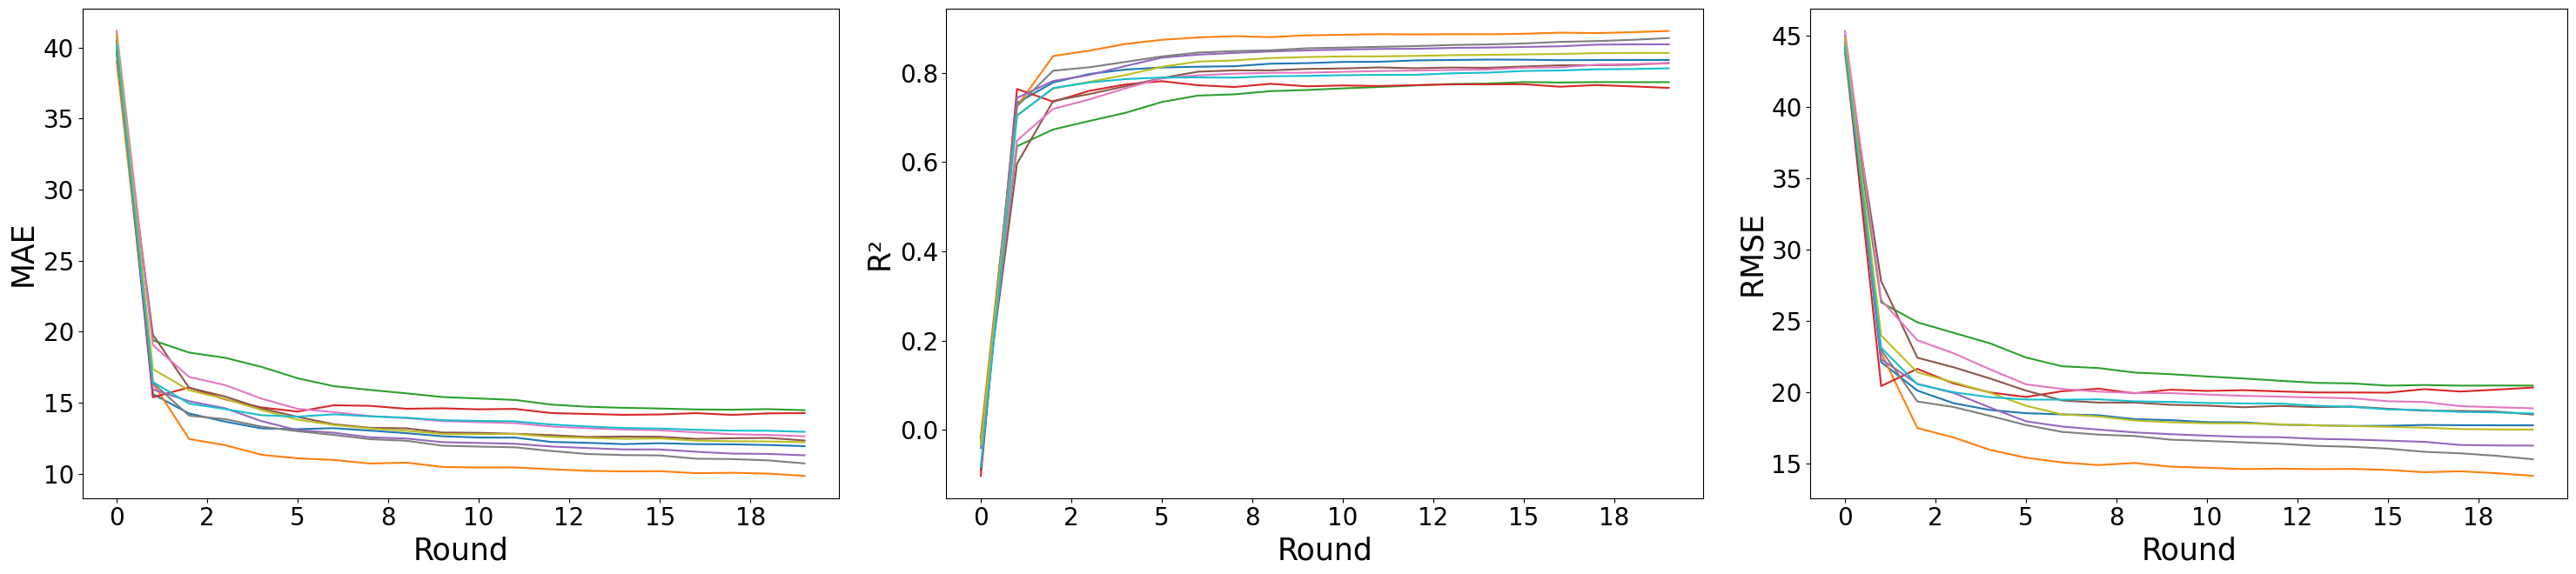

<Figure size 640x480 with 0 Axes>

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 7))
plt.rcParams.update({'font.size': 20})

# Plot MAE
ax1.plot(global_stats_mae[global_stats_mae.columns[1:11]], label='train')
ax1.set_ylabel('MAE', fontsize=25)
ax1.set_xlabel('Round', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Plot R² instead of MAP
ax2.plot(global_stats_r2[global_stats_r2.columns[1:11]], label='train')
ax2.set_ylabel('R²', fontsize=25)
ax2.set_xlabel('Round', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Plot RMSE
ax3.plot(global_stats_rmse[global_stats_rmse.columns[1:11]], label='train')
ax3.set_ylabel('RMSE', fontsize=25)
ax3.set_xlabel('Round', fontsize=25)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plt.tight_layout()
plt.show()

pyplot.savefig(f'federated-FedAVG{EPOCHS}_{comms_round}.png', bbox_inches='tight', dpi=400)

In [35]:
print('size of model: ', sys.getsizeof(global_model.get_weights()))

size of model:  184


### Calculating the average metrics across all rounds and storing them in new columns

In [36]:
global_stats_mae['A'] = (global_stats_mae['0'] + global_stats_mae['1'] + global_stats_mae['2'] + global_stats_mae['3'] +
                         global_stats_mae['4'] + global_stats_mae['5'] + global_stats_mae['6'] + global_stats_mae['7'] +
                         global_stats_mae['8'] + global_stats_mae['9'] + global_stats_mae['test']) / 11

global_stats_r2['A'] = (global_stats_r2['0'] + global_stats_r2['1'] + global_stats_r2['2'] + global_stats_r2['3'] +
                          global_stats_r2['4'] + global_stats_r2['5'] + global_stats_r2['6'] + global_stats_r2['7'] +
                          global_stats_r2['8'] + global_stats_r2['9'] + global_stats_r2['test']) / 11

global_stats_rmse['A'] = (global_stats_rmse['0'] + global_stats_rmse['1'] + global_stats_rmse['2'] + global_stats_rmse['3'] +
                          global_stats_rmse['4'] + global_stats_rmse['5'] + global_stats_rmse['6'] + global_stats_rmse['7'] +
                          global_stats_rmse['8'] + global_stats_rmse['9'] + global_stats_rmse['test']) / 11

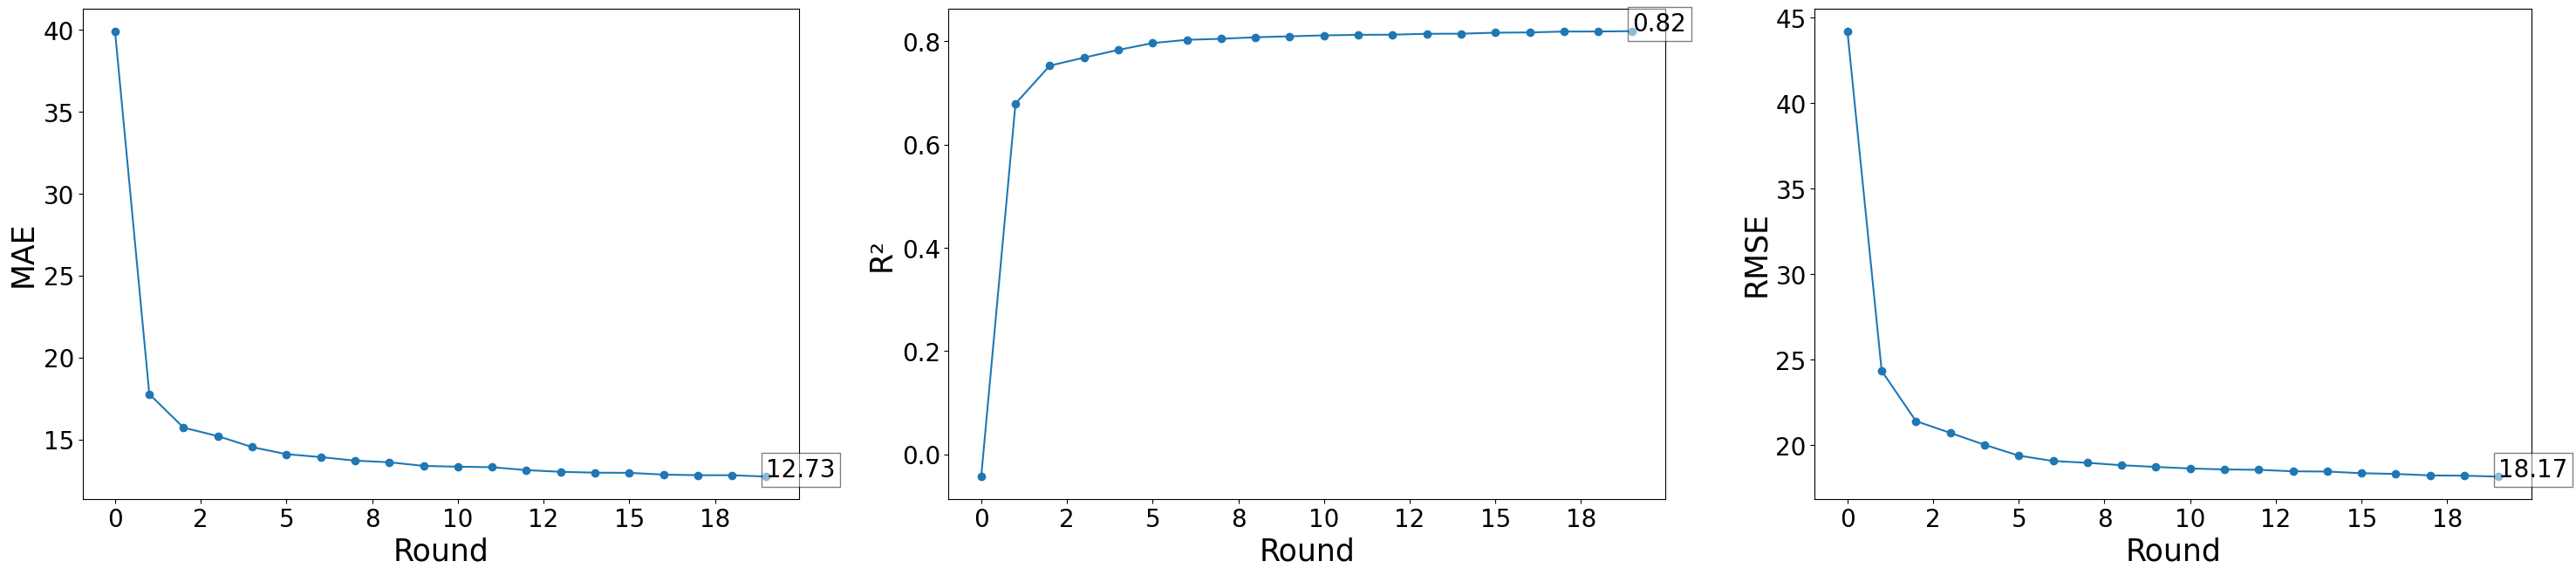

<Figure size 640x480 with 0 Axes>

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 7))
plt.rcParams.update({'font.size': 20})

# Plot MAE
ax1.plot(global_stats_mae['A'], label='train', marker='o')
ax1.set_ylabel('MAE', fontsize=25)
ax1.set_xlabel('Round', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Plot R²
ax2.plot(global_stats_r2['A'], label='train', marker='o')
ax2.set_ylabel('R²', fontsize=25)
ax2.set_xlabel('Round', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Plot RMSE
ax3.plot(global_stats_rmse['A'], label='train', marker='o')
ax3.set_ylabel('RMSE', fontsize=25)
ax3.set_xlabel('Round', fontsize=25)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Add text annotations for the last round values
round_idx = len(global_stats_mae) - 1
ax1.text(round_idx, global_stats_mae['A'][round_idx], f'{global_stats_mae["A"][round_idx]:.2f}', fontsize=20, bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
ax2.text(round_idx, global_stats_r2['A'][round_idx], f'{global_stats_r2["A"][round_idx]:.2f}', fontsize=20, bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
ax3.text(round_idx, global_stats_rmse['A'][round_idx], f'{global_stats_rmse["A"][round_idx]:.2f}', fontsize=20, bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

plt.tight_layout()
plt.show()

pyplot.savefig(f'global-FedAVG-train{EPOCHS}_{comms_round}.png', bbox_inches='tight', dpi=400)

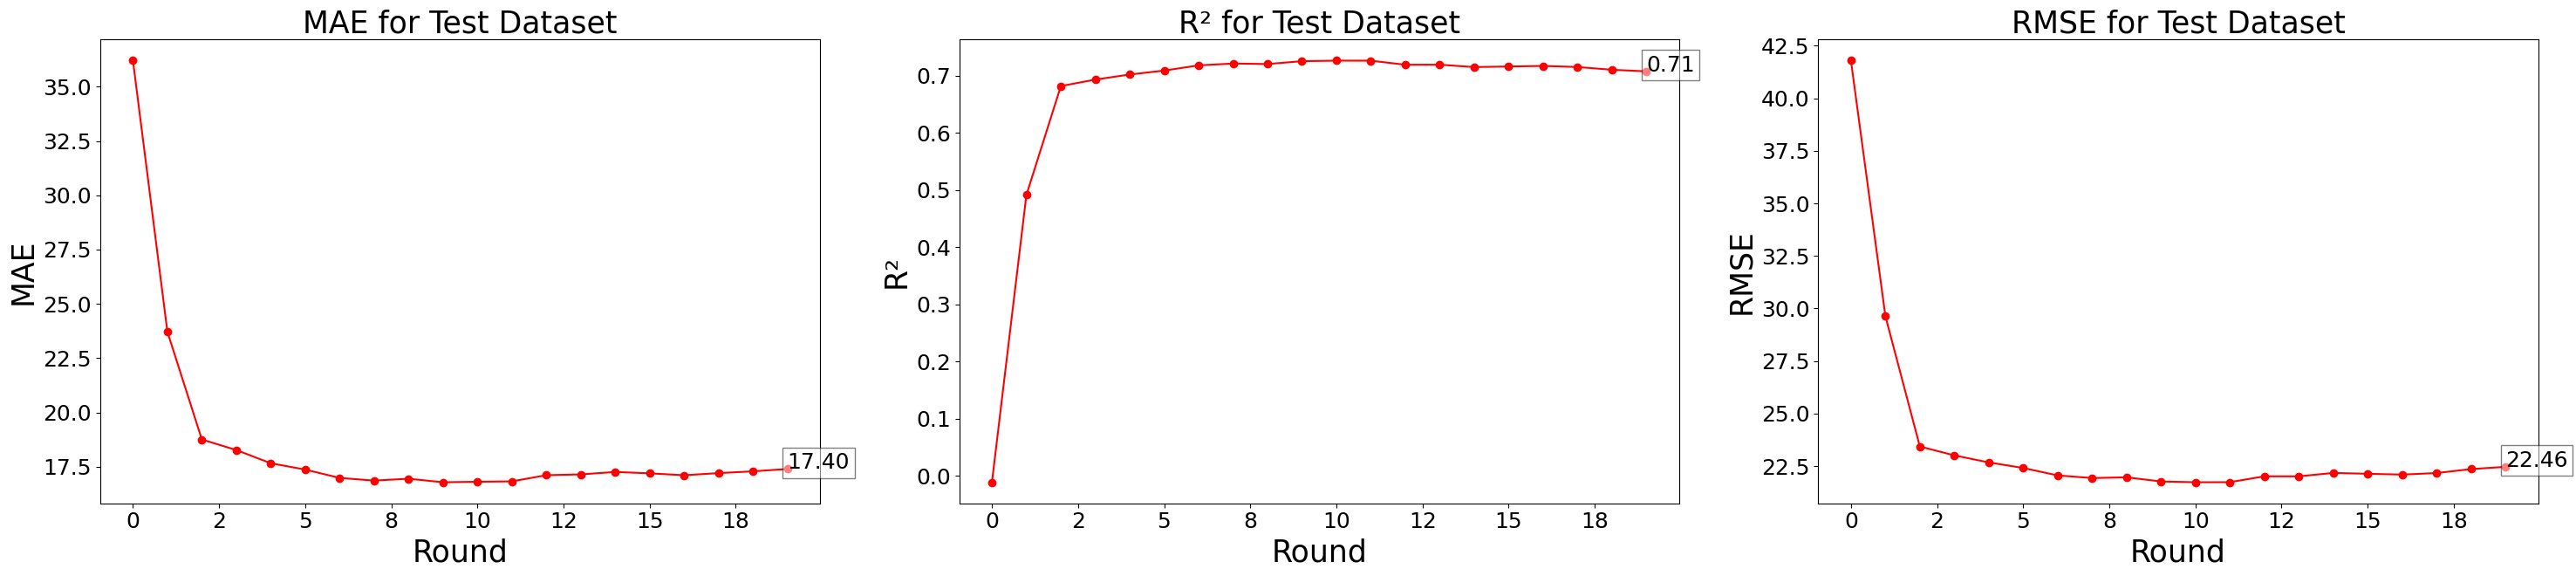

<Figure size 640x480 with 0 Axes>

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 7))
plt.rcParams.update({'font.size': 20})

# Plot MAE
ax1.plot(global_stats_mae['test'], label='test', marker='o', color='red')
ax1.set_ylabel('MAE', fontsize=25)
ax1.set_xlabel('Round', fontsize=25)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Plot R²
ax2.plot(global_stats_r2['test'], label='test', marker='o', color='red')
ax2.set_ylabel('R²', fontsize=25)
ax2.set_xlabel('Round', fontsize=25)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Plot RMSE
ax3.plot(global_stats_rmse['test'], label='test', marker='o', color='red')
ax3.set_ylabel('RMSE', fontsize=25)
ax3.set_xlabel('Round', fontsize=25)
ax3.tick_params(axis='both', which='major', labelsize=18)
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

# Add text annotations for the last round values
round_idx = len(global_stats_mae) - 1
ax1.text(round_idx, global_stats_mae['test'][round_idx], f'{global_stats_mae["test"][round_idx]:.2f}', fontsize=18, bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
ax2.text(round_idx, global_stats_r2['test'][round_idx], f'{global_stats_r2["test"][round_idx]:.2f}', fontsize=18, bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))
ax3.text(round_idx, global_stats_rmse['test'][round_idx], f'{global_stats_rmse["test"][round_idx]:.2f}', fontsize=18, bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

# Set titles
ax1.set_title('MAE for Test Dataset', fontsize=25)
ax2.set_title('R² for Test Dataset', fontsize=25)
ax3.set_title('RMSE for Test Dataset', fontsize=25)

plt.tight_layout()
plt.show()

pyplot.savefig(f'global-FedAVG-test{EPOCHS}_{comms_round}.png', bbox_inches='tight', dpi=400)

In [41]:
global_stats_mae.to_csv('global_stats_mae_FedAvg.csv', index=False)
global_stats_r2.to_csv('global_stats_r2_FedAvg.csv', index=False)
global_stats_rmse.to_csv('global_stats_rmse_FedAvg.csv', index=False)